# 반려동물 등록건수와 유기율을 관계가 있을까?

In [19]:
from database.Database import Database
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [2]:
conn = Database(
    "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    "3306",
    "pethub",
    "addinedu5",
    "pethub"
)

* 반려동물 등록현황 데이터 불러오기

In [3]:
query = """
select rl.region, sum(rpr.count) 
from region_list rl, region_pet_regist rpr 
where rl.id = rpr.region_id 
group by rl.region
"""
result = conn.selectData(query)
region_pet_regist = pd.DataFrame(result, columns=["자치구", "등록수"])
region_pet_regist.head()

,자치구,등록수
0,종로구,10251
1,중구,8600
2,용산구,18676
3,성동구,18346
4,광진구,21875


* 유기현황 데이터 불러오기

In [87]:
query = """
select rl.region, count(pet_type_id) from 
region_pet_abandonment rpa, region_list rl 
where rl.id = rpa.region_id
group by rl.region
"""
result = conn.selectData(query)

region_pet_abandoment_list = []
for row in result:
    region_pet_abandoment_list.append(row)

region_pet_abandoment = pd.DataFrame(region_pet_abandoment_list, columns=["자치구", "유기수"])
region_pet_abandoment.head()

,자치구,유기수
0,종로구,153
1,중구,82
2,용산구,224
3,성동구,157
4,광진구,158


* 두 데이터프레임 합치기

In [88]:
merge_df = pd.merge(region_pet_regist, region_pet_abandoment, on="자치구")
merge_df.head()

,자치구,등록수,유기수
0,종로구,10251,153
1,중구,8600,82
2,용산구,18676,224
3,성동구,18346,157
4,광진구,21875,158


In [89]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   자치구     25 non-null     object
 1   등록수     25 non-null     object
 2   유기수     25 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 732.0+ bytes


In [90]:
merge_df["등록수"] = merge_df["등록수"].astype(int)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   자치구     25 non-null     object
 1   등록수     25 non-null     int64 
 2   유기수     25 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 732.0+ bytes


In [91]:
merge_df.set_index("자치구", inplace=True)

* 등록수와 유기수에 대한 상관계수를 수치와 그래프로 확인

In [92]:
merge_df.corr()

,등록수,유기수
등록수,1.00000,0.37592
유기수,0.37592,1.00000


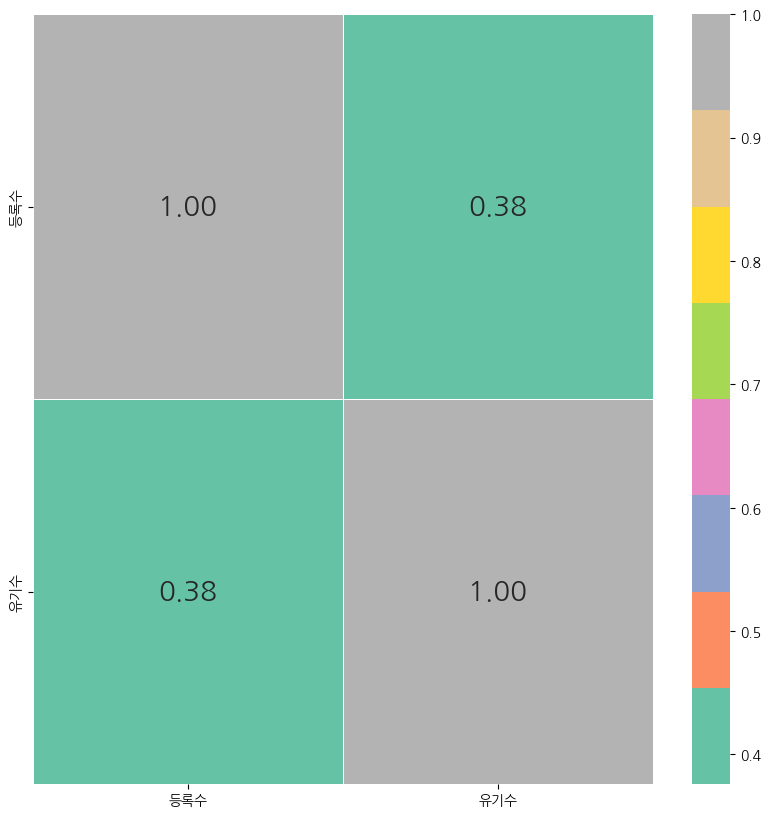

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=merge_df.corr(), annot=True, fmt=".2f", linewidths=.5, cmap="Set2", annot_kws={"size": 20})

plt.show()

* 등록수에 따른 유기율을 알아보자

In [74]:
merge_df["유기율"] = merge_df["유기수"] / merge_df["등록수"] * 100
merge_df = merge_df.sort_values(by="유기율", ascending=False)
merge_df.head()

,등록수,유기수,유기율
자치구,,,
종로구,10251,153,1.492537
마포구,24735,321,1.297756
용산구,18676,224,1.199400
금천구,14178,153,1.079137
강북구,20432,220,1.076742


* 과연 등록수 대비 유기율이 높은 지역은 어디일까?

/var/folders/xd/lnws2p7n09g3nz97545v38d80000gn/T/ipykernel_8178/511928854.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(merge_df["유기수"][i] * 0.98,
/var/folders/xd/lnws2p7n09g3nz97545v38d80000gn/T/ipykernel_8178/511928854.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merge_df["등록수"][i] * 1.03,


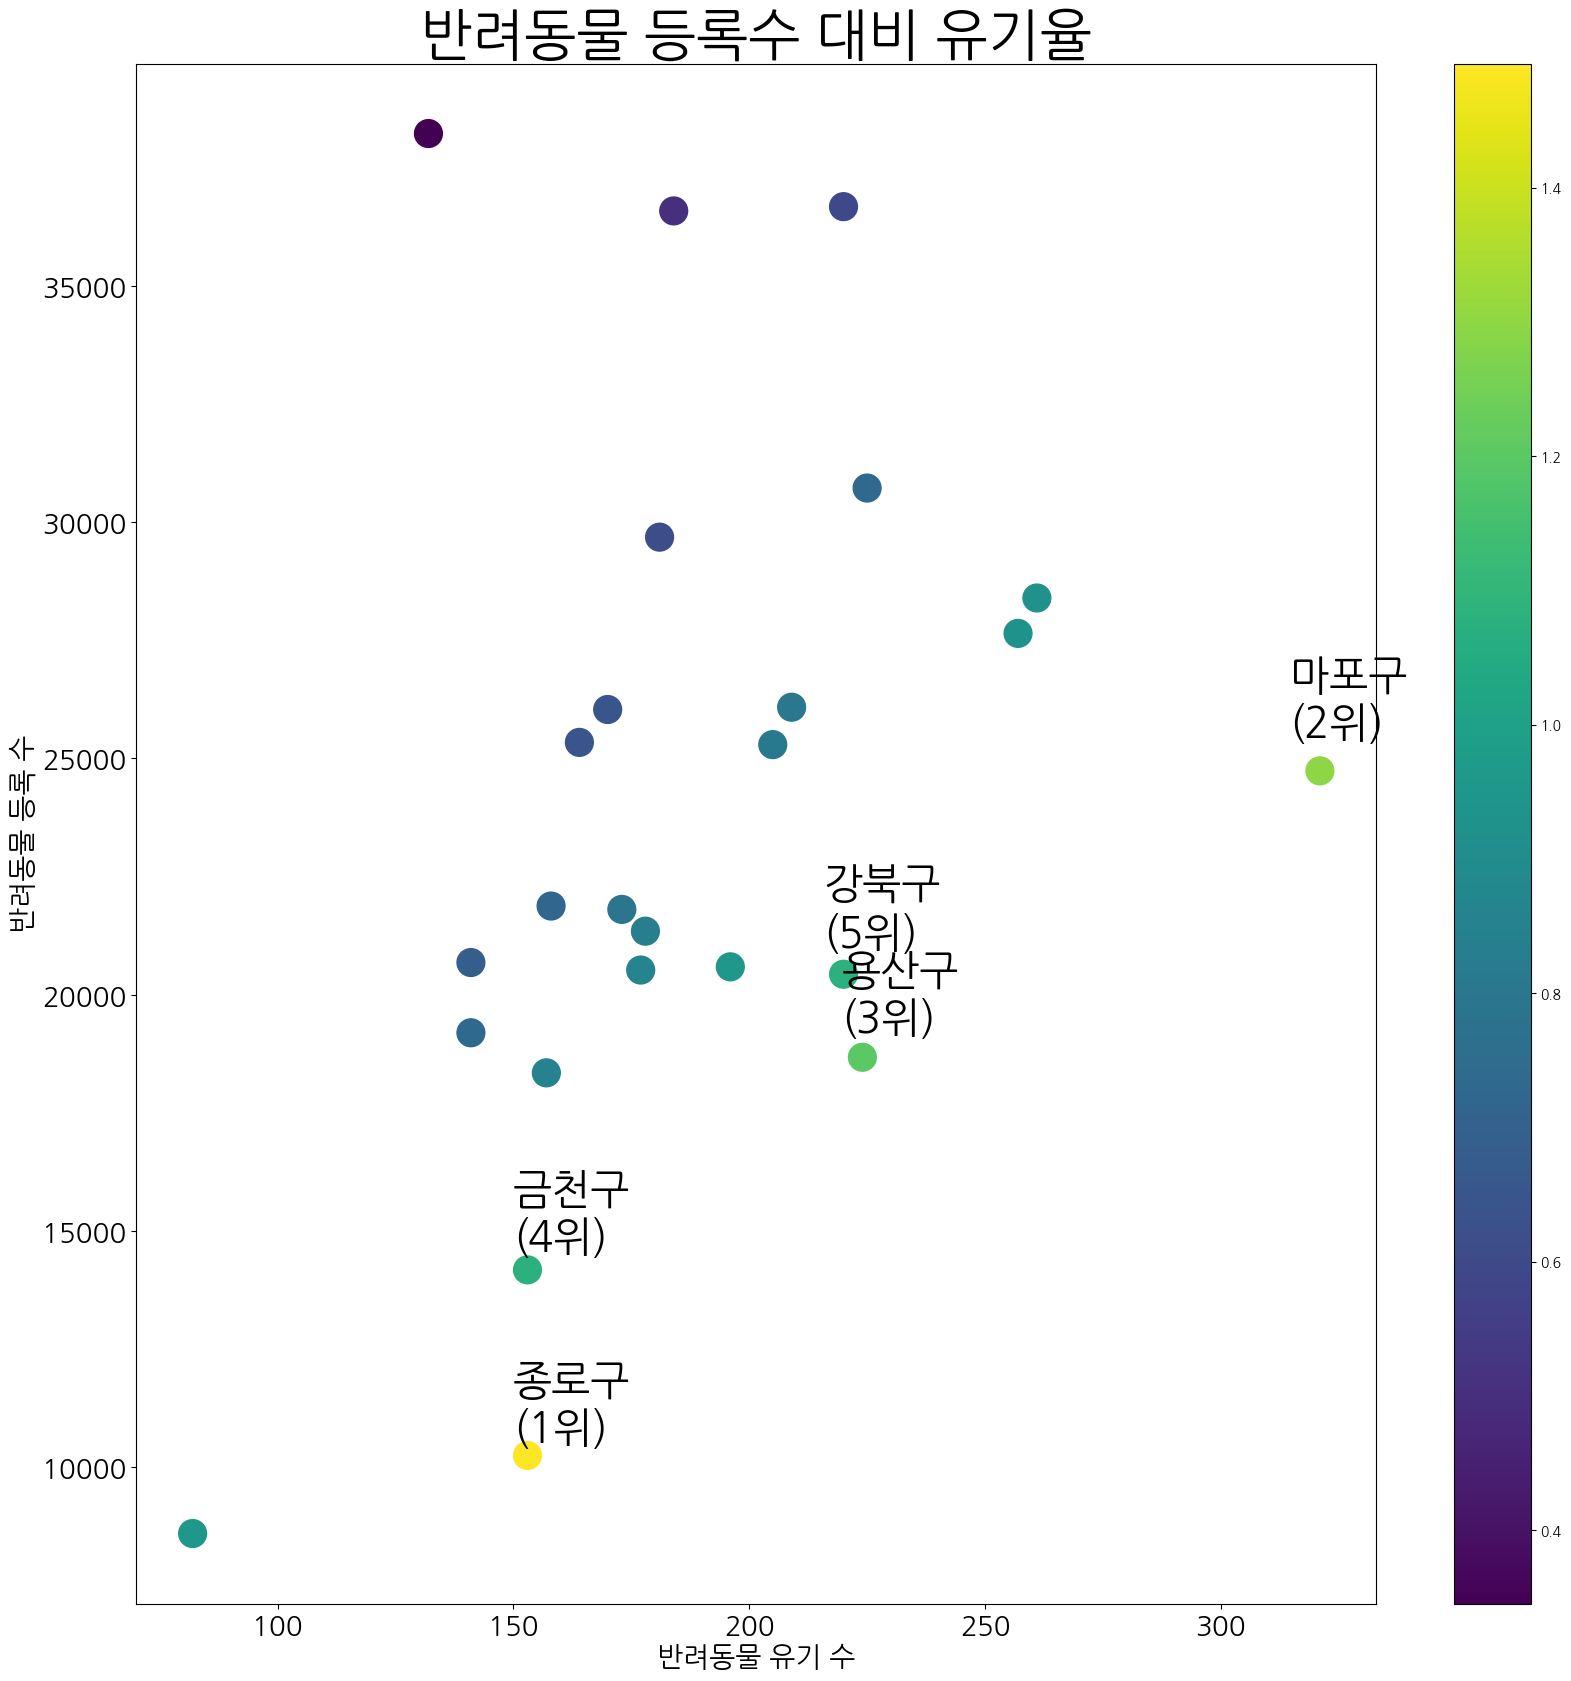

In [86]:
plt.figure(figsize=(20, 20))
plt.scatter(merge_df["유기수"], merge_df["등록수"], c=merge_df["유기율"],
            s=400)

for i in range(5):
    plt.text(merge_df["유기수"][i] * 0.98,
             merge_df["등록수"][i] * 1.03,
             merge_df.index[i] + "\n(" + str(i+1) + "위)", fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.title('반려동물 등록수 대비 유기율', fontsize=40)
plt.xlabel('반려동물 유기 수', fontsize=20)
plt.ylabel('반려동물 등록 수', fontsize=20)
plt.colorbar()
plt.show()